In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
sns.set_style('whitegrid')

In [3]:
# load data
with open('../witt_preprocessing/pickles/dangjin_merged.pkl','rb') as f:
    dangjin_data = pickle.load(f)
with open('../witt_preprocessing/pickles/ulsan_merged.pkl','rb') as f:
    ulsan_data = pickle.load(f)


# preprocess data for modeling

# set time to index
dangjin_data.set_index('time', inplace=True)
ulsan_data.set_index('time', inplace=True)

# dangjin - sum target values
dangjin_data['dangjin_sum'] = dangjin_data['dangjin'] + dangjin_data['dangjin_floating'] + dangjin_data['dangjin_warehouse']
dangjin_data.drop(columns=['dangjin','dangjin_floating','dangjin_warehouse'], inplace=True)

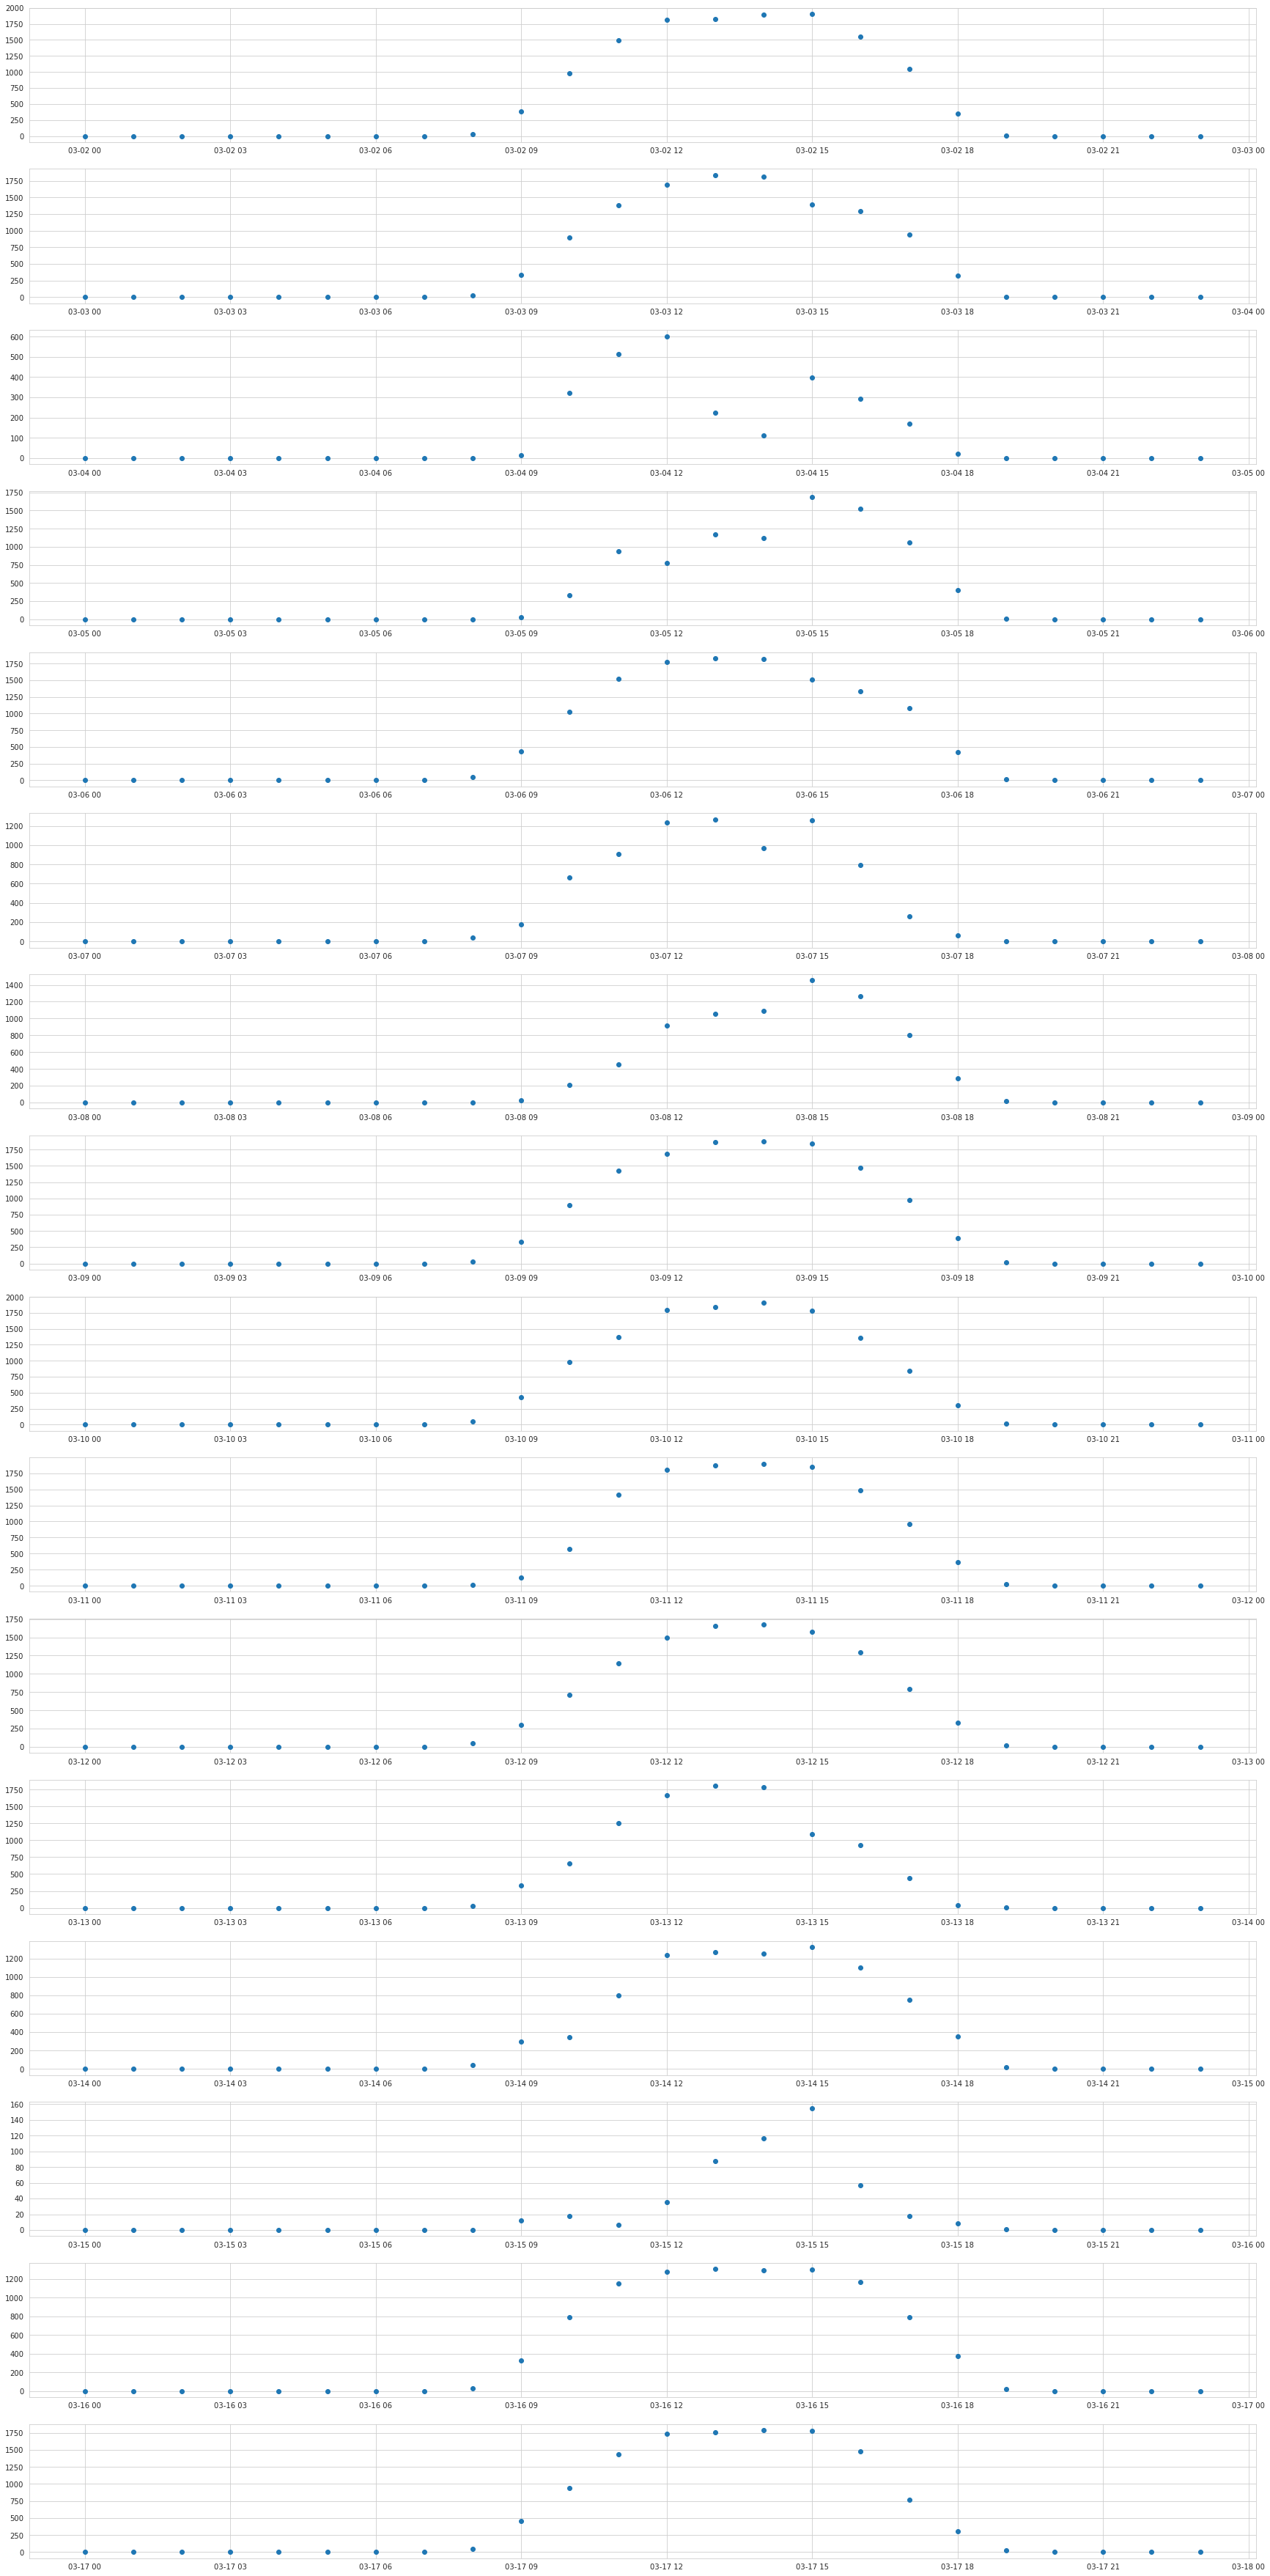

In [7]:
# investigate peaks
N = 16
fig, ax = plt.subplots(N,1, figsize=(30,4*N))

for n in range(N):
    i = 24*n
    dangjin_sample = dangjin_data.iloc[i:i+24]
    ax[n].scatter(dangjin_sample.index, dangjin_sample['dangjin_sum'])

vestigate peaks
N = 16
fig, ax = plt.subplots(N,1, figsize=(30,4*N))

for n in range(N):
    i = 24*n
    dangjin_sample = dangjin_data.iloc[i:i+24]
    ax[n].scatter(dangjin_sample.index, dangjin_sample['dangjin_sum'])

# 주로 12~15시에 분포

## Only peaks

In [10]:
x_peaks_n_row = dangjin_data.shape[0] // 24
peaks_list = []

for i in range(x_peaks_n_row):
    # slicing 1 day
    dangjin_sample = dangjin_data.iloc[i*24:i*24+24]
    # find peak
    peak = dangjin_sample['dangjin_sum'].argmax()
    # only using the peak hour
    peaks_list.append(dangjin_sample.iloc[peak])

peaks = pd.concat(peaks_list, axis=1).transpose()

## Selecting columns

In [11]:
peaks.columns

Index(['Temperature_obs', 'Humidity_obs', 'Cloud_obs', 'Wind_X_obs',
       'Wind_Y_obs', 'Temperature_fcst', 'Humidity_fcst', 'Cloud_fcst',
       'Wind_X_fcst', 'Wind_Y_fcst', 'Day_cos', 'Day_sin', 'Year_cos',
       'Year_sin', 'dangjin_sum'],
      dtype='object')

In [12]:
x_cols = ['Temperature_fcst', 'Humidity_fcst', 'Cloud_fcst','Day_cos','Day_sin','Year_cos', 'Year_sin']
y_cols = ['dangjin_sum']

## Modeling (rf)
: check result in random_forest_experiment.ipynb

In [21]:
def validate(model, data, x_cols, y_cols, test_size=0.2):
    # input-target split
    x = data.loc[:,x_cols]
    y = data.loc[:,y_cols]

    # train-test split
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, shuffle=False)

    # fit and predict
    model.fit(train_x, train_y)
    predict = model.predict(test_x)

    return predict, test_y

In [22]:
def evaluate(predict, y):
    return abs(predict - y.iloc[:,0]).sum(axis=0)

In [23]:
# rf
model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, min_samples_leaf=11)
predict, test_y = validate(model, peaks, x_cols, y_cols)

<ipython-input-21-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


In [24]:
test_y['predict'] = predict
with open('peak_prediction.pkl', 'wb') as f:
    pickle.dump(test_y, f)

## Modeling (nn) -> loss does not converges...

In [154]:
# dataloader (for torch)
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

## custom Dataset
class SolarDataset(Dataset):
    def __init__(self, data, x_cols, y_cols):
        x = data.loc[:,x_cols]
        y = data.loc[:,y_cols]

        # standardization
        self.x = (x - x.mean(axis=0)) / x.std(axis=0)
        self.y = (y - y.mean(axis=0)) / y.std(axis=0)
        #self.x = x
        #self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        input = self.x.iloc[idx].to_numpy(dtype=np.float32)
        target = self.y.iloc[idx].to_numpy(dtype=np.float32)
        return input, target
    
## trainloader and testloader
data = dangjin_data

i = int(data.shape[0] * 0.8)
data_train = data.iloc[:i]
data_test = data.iloc[i:]

dj_trainset = SolarDataset(data_train, x_cols, y_cols)
dj_testset = SolarDataset(data_test, x_cols, y_cols)

dj_trainloader = DataLoader(dj_trainset, batch_size=4, shuffle=True)
dj_testloader = DataLoader(dj_testset, batch_size=4, shuffle=True)

In [155]:
# nn (torch)
import torch
import torch.nn as nn
import torch.nn.functional as F


# model
class Net(nn.Module):
    def __init__(self, h1, h2):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(7,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

# train
net = Net(32,32)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.L1Loss()
EPOCH = 4

for epoch in range(EPOCH):
    print('Epoch:', epoch)
    for i, data in enumerate(dj_trainloader):
        input, target = data

        # forward and loss
        output = net(input)
        loss = criterion(output, target)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # save loss
        if i%200 == 0:
            print(loss.item())

Epoch: 0
0.6792424917221069
0.37515854835510254
0.8870682716369629
1.055910348892212
0.8718140125274658
0.9258735179901123
0.34782376885414124
0.650760293006897
0.714382529258728
0.6001906394958496
0.49188658595085144
0.7750867605209351
0.5887898802757263
0.4373519718647003
0.650760293006897
0.4711689352989197
0.5813882350921631
0.6039083003997803
0.4636816382408142
0.5297327041625977
0.48306214809417725
0.6481130719184875
0.4348573684692383
0.5712350606918335
0.6783555746078491
0.3955708146095276
Epoch: 1
0.5190708637237549
0.649871826171875
0.46104320883750916
0.7808362245559692
0.33308759331703186
0.4792798161506653
0.5823466181755066
0.6427639126777649
0.8998563289642334
0.503541111946106
0.4675440192222595
0.3998257517814636
0.4096970856189728
0.40790075063705444
0.4751509428024292
0.5987058281898499
0.6210081577301025
0.5523686408996582
0.6791625022888184
0.5592278242111206
0.6839815378189087
0.597824215888977
0.6954360008239746
0.3793158531188965
0.43768420815467834
0.6014728546

## HP optimization(rf)

In [58]:
hps = np.arange(8,16)
ITER = 3
err_by_hp = {x:[] for x in hps}

for x in hps:
    for _ in range(ITER):
        model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, min_samples_leaf=x)
        predict, test_y = validate(model, peaks, x_cols, y_cols)
        err_by_hp[x].append(evaluate(predict, test_y))
        
err_by_hp = pd.DataFrame(err_by_hp)

<ipython-input-33-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
<ipython-input-33-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
<ipython-input-33-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
<ipython-input-33-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
<ipython-input-33-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected

In [62]:
err_by_hp

,8,9,10,11,12,13,14,15
0,46544.607434,45615.622107,46086.653521,45695.491697,46032.777126,45885.624229,46207.307470,46437.259692
1,46461.615344,45660.949988,45683.557390,45040.405258,46410.331730,45813.434912,46148.073741,45363.520000
2,46549.431341,46580.677306,46333.529428,46522.459780,45393.808687,45950.987085,46207.705740,45543.041950
